In [1]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
sns.set_theme(style='ticks', color_codes=True)
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs

%config InlineBackend.figure_format = 'retina'

In [2]:
# get surface mass balance
smb = {}

# reference simulation
smb['reference'] = np.load('../pdd-model/smb.npy')

for s in ['reduce-seasonality', 'glacial-climate']:
    smb[s] = np.load(f'{s}/smb.npy')

### Surface mass balance maps

In [3]:
# read orography & lat-lon bounds
# "switch" dimensions to x = lon & y = lat
grl  = np.transpose(np.load('../model-input/grl20_surface.npy'))
xlon = np.transpose(np.load('../model-input/grl20_lon.npy'))
ylat = np.transpose(np.load('../model-input/grl20_lat.npy'))

# mask ocean (all elevation values below 0)
seamask = np.ones(np.shape(grl), dtype=bool)
seamask[grl > 0] = False

# map projection
trans = ccrs.PlateCarree()
proj = ccrs.Stereographic(central_latitude=90, central_longitude=316)

# add coastline of greenland
# get path to shapefile
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
# read shapefile
shpfile = shpreader.Reader(shpfilename)
# select greenland only
greenland = [country.geometry for country in shpfile.records() \
             if country.attributes["NAME_LONG"] == "Greenland"]

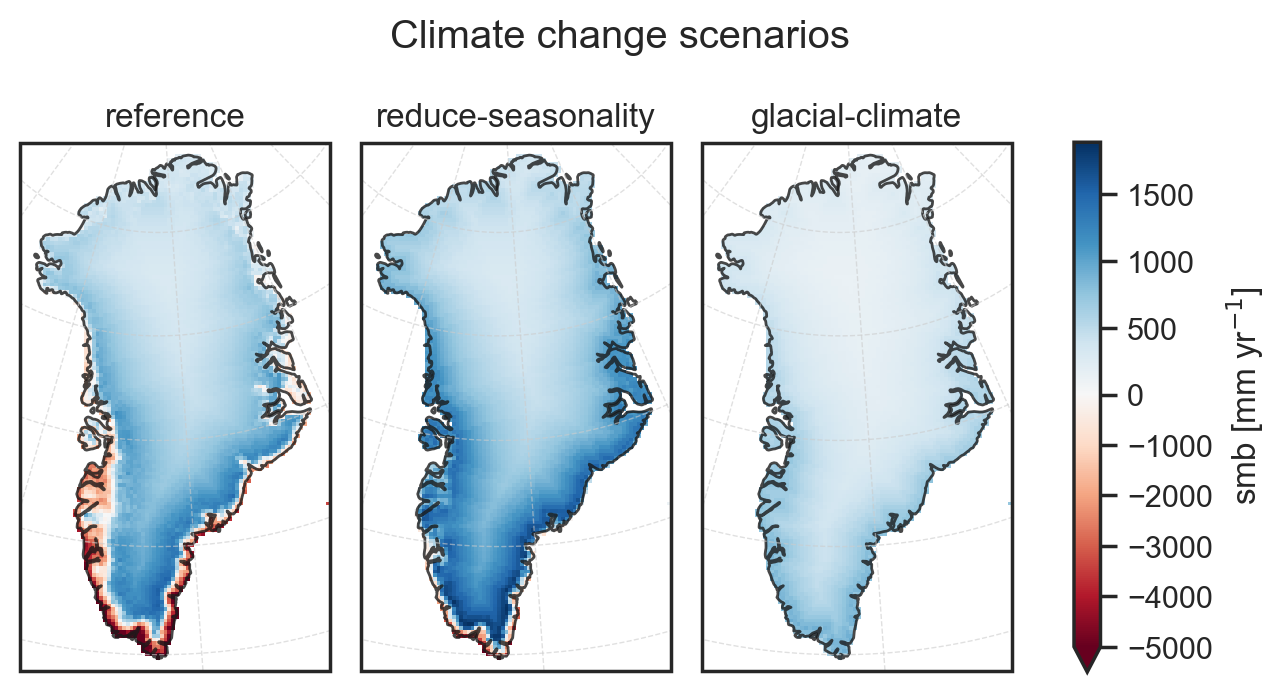

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(8,4), gridspec_kw=dict(wspace=0.1),
                        subplot_kw=dict(projection = proj))
axs = axs.flatten()
norm = colors.TwoSlopeNorm(vcenter=0,
                           vmax=np.max(list(smb.values())),
                           vmin=-5000)
cbar_ticks=[-5000, -4000, -3000, -2000, -1000, 0, 500, 1000, 1500]

for i, s in enumerate(smb.keys()):
    # sea-mask input field
    plotsmb = np.ma.masked_where(seamask, smb[s])
    # plotting...
    cm = axs[i].pcolormesh(xlon, ylat, plotsmb, shading='nearest',
                           transform=trans, cmap='RdBu', norm=norm)
    
    
    # optionally, adjust colorbar ticks
    axs[i].set_title(s)
    # add greenland coastline
    axs[i].add_geometries(greenland, crs=trans, fc='none',
                  ec='k', alpha=0.8)
    axs[i].gridlines(alpha=.6, ls='--', lw=.5)

fig.colorbar(cm, extend='min', shrink=0.86,
             label=r"smb [mm yr$^{-1}$]",
             ticks=cbar_ticks, ax=axs)
fig.suptitle("Climate change scenarios")
fig.savefig('smb-map.png', dpi=300, bbox_inches="tight")

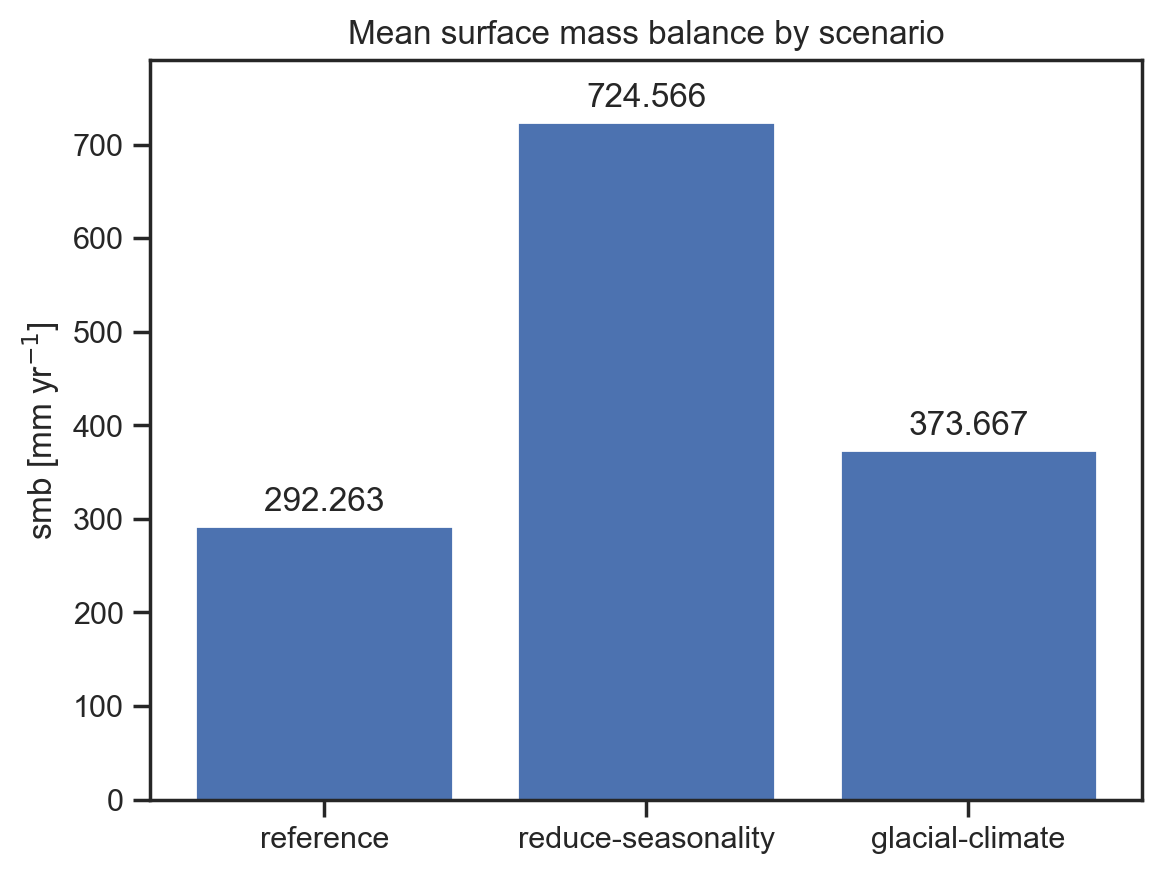

In [5]:
sims = []    # simulation names
meansmb = [] # mean smb within greenland
for s, vals in smb.items():
    meansmb.append(np.mean(np.ma.masked_where(seamask, vals)))
    sims.append(s)

fig, ax = plt.subplots()
x = np.arange(3)
b = ax.bar(x, meansmb)
ax.bar_label(b, padding=3)

# further tweaking
ax.set_ylim(top=790)
ax.set_title("Mean surface mass balance by scenario")
ax.set_ylabel(r"smb [mm yr$^{-1}$]")
ax.set_xticks(x, sims)
fig.savefig('smb-bars.png', dpi=300, bbox_inches="tight")